# Book Ratings: Exploratory Data Analysis

Questions of Interest:
- Distribution of ratings by book
- Most rated books
- Highest rated books
- Highest variance of ratings (most controversial books)
- Distribution of ratings by user
- "Average" ratings per user: mean vs weighted vs normalized
- Books not on a to-read list
- Books most people have in common (network analysis)
- Correlations between average rating and length of to-read list?
- Correlations between number of rating and length of to-read list?
- Ratio of number of ratings (have read) vs. to-read. (What books do people say they want to read, but aren't actually reading?)
- Variety of genres per user
- Rating distribution per genre
- Genres most likely to be rated highly by the same users?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_summary import DataFrameSummary
import seaborn as sns

import networkx as nx

pd.set_option('display.max_columns', 100)

In [2]:
# Load the data

df_books = pd.read_pickle('datasets/clean/books_clean.pkl')
df_ratings = pd.read_csv( 'datasets/raw/ratings_raw.csv' )
df_to_read = pd.read_csv( 'datasets/raw/to_read_raw.csv' )
df_tags = pd.read_csv( 'datasets/raw/tags_raw.csv' )
df_book_tags = pd.read_csv( 'datasets/raw/book_tags_raw.csv')

# Exploring the Books DataFrame

There are 1,000 books in this dataset. Descriptions of the columns are below. It's noted if the column is missing entries.

**Columns**
- **books_count**: the number of editions for a given work.
- **authors**: the authors(s) name.
- **original_publication_year**: (9979 non-null)  
- **original_title**: (9415 non-null)  
- **title**: similar to *original_title* and includes the order it appears in a books series. 
- **language_code**: unclear if this is the language of the original edition or post popular edition. (8916 non-null, object) 
- **average_rating**: the mean rating out of 1-5 stars.
- **ratings_count**: presumably, the number of unique users who have rated this book. It is lower than *work_ratings_count*. 
- **work_ratings_count**: number of total ratings a book received, may include multiple ratings per user?
- **work_text_reviews_count**: number of written reviews, which is different than numerical ratings (number of stars).
- **ratings_1**: number of 1-star ratings. 
- **ratings_2**: number of 2-star ratings.
- **ratings_3**: number of 3-star ratings.
- **ratings_4**: number of 4-star ratings.  
- **ratings_5**: number of 5-star ratings.

In [3]:
df_books.head(3)

,book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317
1,2,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543
2,3,226,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439


# 1. Distribution of Ratings (1-5 Stars)

* The distribution of average rating per book is left-skewed with a mean of **4.00219**. 
* Most books in this dataset (~90%) have been reviewed between 10,000 and 100,000 times, with a **mean of 59,687 reviews**.
* When a book is reviewed more often, the min, max, and mean ratings converge to the mean, 4.0012. Which is to be expected, statistically. 
* The min and max ratings had the largest spread for books that were rated 10-99 times. 

In [4]:
mean_rating = df_books.average_rating.mean()
print('The mean book rating (out of 5-stars) is:', mean_rating)

The mean book rating (out of 5-stars) is: 4.002191000000001


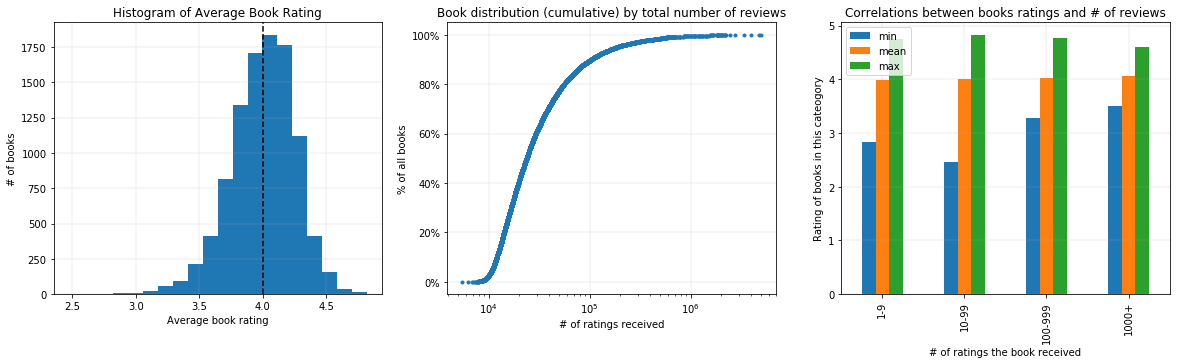

In [5]:
# Plot book statistics: distribution of mean rating, number of ratings, and ratings per group.

plt.figure(figsize=(20,5))

# Distribution of average book rating
ax1 = plt.subplot(1,3,1)
plt.hist(df_books.average_rating, bins=20);
plt.axvline(x=mean_rating, c='black', linestyle='--')
ax1.set_xlabel('Average book rating');
ax1.set_ylabel('# of books');
ax1.set_title('Histogram of Average Book Rating', fontsize=12);
ax1.grid(linewidth=.2);

# Distribution of number of book ratings
def ecdf(array):
    """Compute ECDF for 1D array of measurement data."""
    # sort array to use as the x axis
    x = np.sort(array)    
    # use np.arange to create the y axis for cdf from 1/len to 1
    y = np.arange(1, len(array)+1)/len(array)
    return x,y

ax2 = plt.subplot(1,3,2)
x,y = ecdf(df_books.work_ratings_count)
ax2.plot(x, y, marker = '.', linestyle='none');
ax2.set_yticklabels(['{:.0%}'.format(x) for x in ax2.get_yticks()])
ax2.set_xscale('log');
ax2.set_xlabel('# of ratings received');
ax2.set_ylabel('% of all books');
ax2.set_title('Book distribution (cumulative) by total number of reviews');
ax2.grid(linewidth=.2);

# Correlation between average rating and count
ax3 = plt.subplot(1,3,3)
count_cat = np.log10(df_books.work_ratings_count)//1
book_by_rev_count = df_books.groupby(count_cat)['average_rating'].agg(['min','mean','max'])
book_by_rev_count.index = ['1-9','10-99','100-999','1000+']
book_by_rev_count.plot(kind='bar', ax=ax3);
ax3.set_xlabel('# of ratings the book received');
ax3.set_ylabel('Rating of books in this cateogory');
ax3.set_title('Correlations between books ratings and # of reviews');
ax3.legend(loc='upper left');
ax3.grid(linewidth=.2);

# 2. Correlation between Average Rating and Numerical Features

* A user is more likely to take the time to write a review if they're rating the book with 4 stars. They're least likely to leave a review with a 1-star rating.
* The strongest indicator of a low average rating is the presence of 2-star ratings. Mathematically, we might expect that a 1-star rating would bring the average down more. However, 2-star ratings are less common than 1-star ratings, which might make them more significant.
* The older the book, the more editions it will have. 
* Having more editions of a book has a slightly negative correlation with average rating.

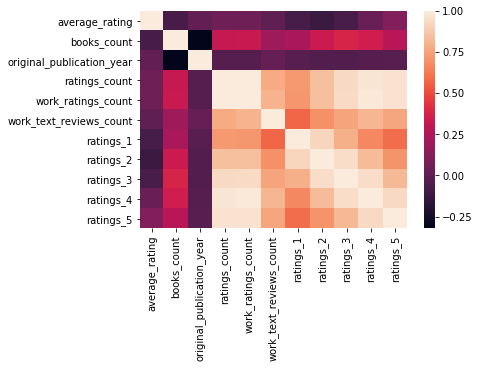

In [6]:
# plot correlation matrix for numerical columns

numerical_cols = ['average_rating', 'books_count', 'original_publication_year',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']

corr = df_books[numerical_cols].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


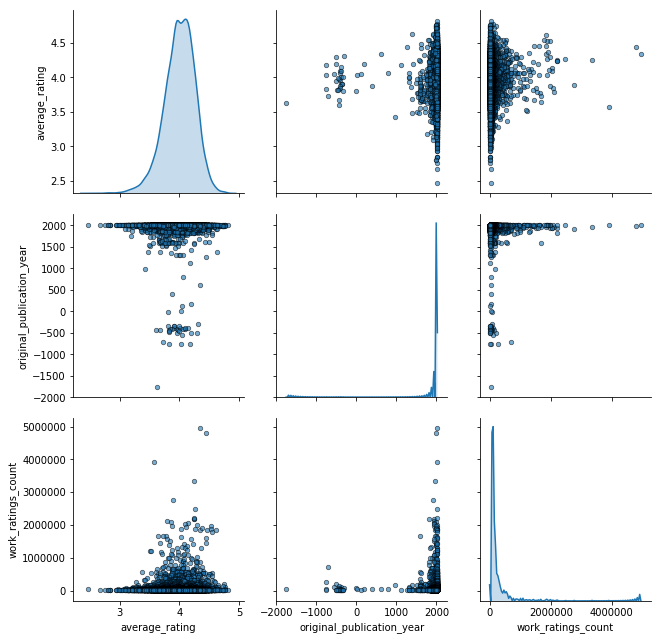

In [7]:
# Create a pair plot with a density plot of the # diagonal and format the scatter plots.

# Consider coloring it by a variable like: hue = (2-10, 11-100, 101-200 ratings given)

sns.pairplot(df_books[['average_rating', 'original_publication_year', 'work_ratings_count']], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor': 'k'},
             height = 3)
plt.show()

/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


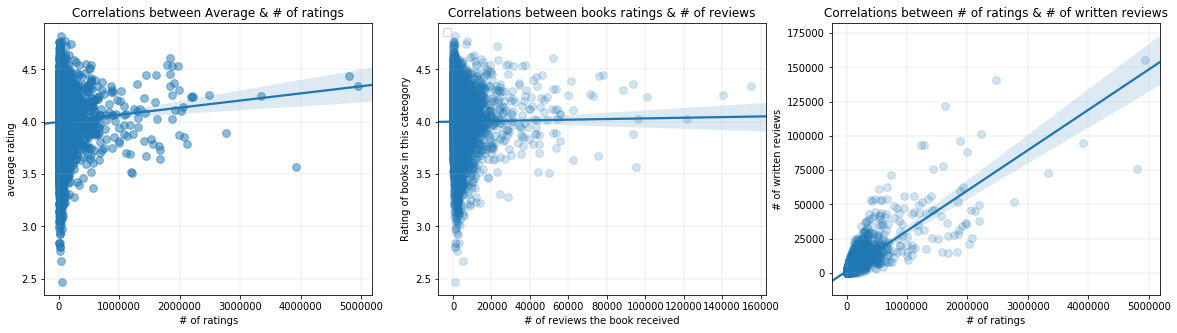

In [8]:
# Plot correlation of Average rating vs. # of ratings vs # written reviews.

plt.figure(figsize=(20,5))

# Correlation between average rating and review count
## There appears to be only a slight rise in average rating when a book is reviewed more often.
ax1 = plt.subplot(1,3,1)
sns.regplot(x="work_ratings_count", y="average_rating", data=df_books, fit_reg = True, 
            scatter_kws={'alpha':0.5, 's':60});
ax1.set_xlabel('# of ratings');
ax1.set_ylabel('average rating');
ax1.set_title('Correlations between Average & # of ratings', fontsize=12);
ax1.grid(linewidth=.2);

# Correlation between average rating and # written reviews
ax2 = plt.subplot(1,3,2)
sns.regplot(x="work_text_reviews_count", y="average_rating", data=df_books, fit_reg = True, 
            scatter_kws={'alpha':0.2, 's':60})
ax2.set_xlabel('# of reviews the book received');
ax2.set_ylabel('Rating of books in this cateogory');
ax2.set_title('Correlations between books ratings & # of reviews');
ax2.legend(loc='upper left');
ax2.grid(linewidth=.2);

# Correlation between # of ratings and # written reviews
ax3 = plt.subplot(1,3,3)
sns.regplot(x="work_ratings_count", y="work_text_reviews_count", data=df_books, fit_reg = True, 
            scatter_kws={'alpha':0.2, 's':60})
ax3.set_xlabel('# of ratings');
ax3.set_ylabel('# of written reviews');
ax3.set_title('Correlations between # of ratings & # of written reviews');
ax3.grid(linewidth=.2);

## 3. Most commonly read books: Young adult fantasy series
The first book in popular young adult series (The Hunger Games, Harry Potter, Twilight, Divergent, and the Hobbit).  
Books assigned in school. Many books on this list are also banned books or frequently challenged books: Harry Potter, To Kill a Mockingbird, The Great Gatsby, The Catcher in the Rye.

### A lot of people have read Twilight. Most didn't think it was very good.
Vampires, werewolves, and moody teens have been popular in recent years and the first book of the Twilight series was rated by nearly 400,000 GoodReads users. It's the 3rd most rated book on this dataset. However, you have to go all the way down the list to the 46th most rated book ("Eat, Pray, Love") before find one that's rated lower than Twilight's 3.57 average.

In [9]:
# Most often rated books

df_books.sort_values(by='work_ratings_count', ascending=False).head(10)[[
    'title', 'work_ratings_count', 'average_rating']]

,title,work_ratings_count,average_rating
0,"The Hunger Games (The Hunger Games, #1)",4942365,4.34
1,Harry Potter and the Sorcerer's Stone (Harry P...,4800065,4.44
2,"Twilight (Twilight, #1)",3916824,3.57
3,To Kill a Mockingbird,3340896,4.25
4,The Great Gatsby,2773745,3.89
5,The Fault in Our Stars,2478609,4.26
11,"Divergent (Divergent, #1)",2216814,4.24
6,The Hobbit,2196809,4.25
9,Pride and Prejudice,2191465,4.24
7,The Catcher in the Rye,2120637,3.79


## 4. Highest rated books: 
**Calvin and Hobbes** and **Harry Potter** top the charts for most beloved books.

In [10]:
# Highest rated books

books_by_rating = df_books.sort_values(by='average_rating', ascending=False)
books_by_rating.head(10)[['title', 'work_ratings_count', 'average_rating']]

,title,work_ratings_count,average_rating
3627,The Complete Calvin and Hobbes,29968,4.82
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",33424,4.77
861,"Words of Radiance (The Stormlight Archive, #2)",108176,4.77
8853,Mark of the Lion Trilogy,9547,4.76
7946,ESV Study Bible,10784,4.76
4482,It's a Magical World: A Calvin and Hobbes Coll...,23429,4.75
6360,There's Treasure Everywhere: A Calvin and Hobb...,17285,4.74
421,"Harry Potter Boxset (Harry Potter, #1-7)",204125,4.74
3752,"Harry Potter Collection (Harry Potter, #1-6)",26274,4.73
6919,The Indispensable Calvin and Hobbes,16911,4.73


## Highest rate books after Calvin and Hobbes and Harry Potter: Christian Literature and Fantasy Novels
- Words of Radiance = epic fantasy novel
- Mark of the Lion Trilogy = historical fiction with a christian heroine
- A Court of Mist and Fury = fantasy romance
- The Revenge of the Baby-Sat = actually still Calvin and Hobbes
- The Absolute Sandman = fantasy
- The Way of Kings, Part 1 = fantasy

In [11]:
books_by_rating[~books_by_rating.title.str.contains('Calvin') & 
                ~books_by_rating.title.str.contains('Harry')].head(11)[[
                'title', 'work_ratings_count', 'average_rating']]

,title,work_ratings_count,average_rating
861,"Words of Radiance (The Stormlight Archive, #2)",108176,4.77
8853,Mark of the Lion Trilogy,9547,4.76
7946,ESV Study Bible,10784,4.76
9565,Attack of the Deranged Mutant Killer Monster S...,12197,4.72
1307,A Court of Mist and Fury (A Court of Thorns an...,126491,4.72
8977,The Revenge of the Baby-Sat,12946,4.71
9075,Preach My Gospel: A Guide To Missionary Service,10194,4.71
5918,Life Application Study Bible: NIV,14774,4.67
9140,"The Way of Kings, Part 1 (The Stormlight Archi...",10117,4.67
4777,The Holy Bible: English Standard Version,23236,4.66


## 5. Book Ratings: Mean, Count, and Variance

/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


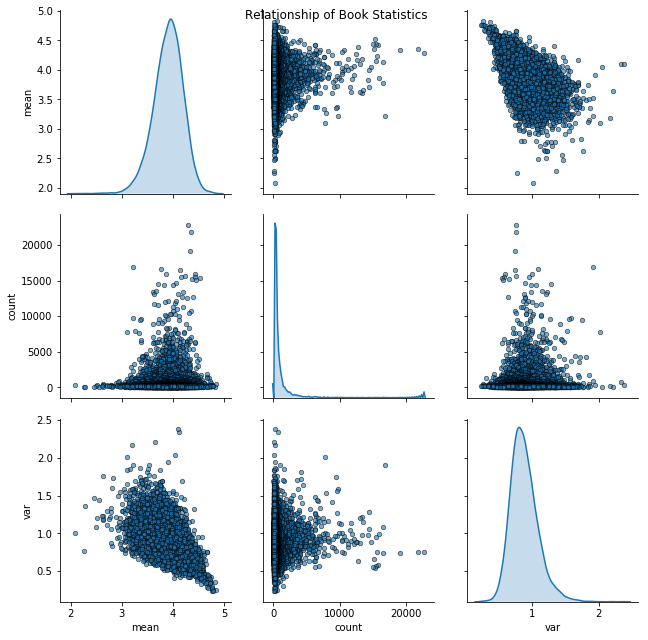

In [12]:
#Examine book rating stats

# Calculate statistics for each book
book_stats = df_ratings.groupby('book_id')['rating'].agg(['mean', 'count','std','var'])

# Create a pair plot with a density plot of the # diagonal and format the scatter plots.

sns.pairplot(book_stats[['mean', 'count', 'var']], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor': 'k'},
             height = 3)
plt.suptitle('Relationship of Book Statistics')
plt.show()

# 6. Religion and Sexuality are controversial

The most polarizing people and ideas often have the strongest followings. When building book recommendations, highly contested books may be the most helpful indicators for future suggestions.

Below is a list of 15 books that a significant number of people have rated (count > 300) with wide spread of high and low ratings (VAR > 1.5).

* ***The Book of Mormon***, ***The Qur'an***, and ***The Holy Bible*** are all in the top 15 most controversial books in our dataset. Though not holy texts, most other books on the list have a foundation in religion.

* ***The Secret*** is a self help book teaching positive-thinking to directly affect one's life. 

* ***Atlas Shruged*** is a novel with controversial commentary on government and theology. Ayn Rand's other novel, ***Fountainhead*** also made the list when it was narrowed down to books that were rated at least 1000 times.

* ***The Shack*** is a Christian based novel with an unconventional interpretations of God and the Holy Trinity.

* ***Left Behind*** is a novel that takes place during the Rapture and the weeks that follow.

* The ***Twilight*** series is a love saga about vampires and werewolves. On the surface that doesn't seem controversial, however it's themes include prejudice, Mormonism, teen sex vs. abstinence, and feminism. The book is both widely loved and widely hated.

* Last to be discussed, but definitely not least on the list is the ***Fifty Shades of Grey*** series. This widely read erotic romance trilogy has been accused of romanticizing abusive relationships and misrepresenting BDSM practices.



In [13]:
# Identify the books with high VAR (>1.5) and significant COUNT (>300)

# Add 'title' column to the ratings dataframe
book_stats_with_titles = pd.merge(book_stats, df_books[['book_id', 'title']], 
                               how='left', on='book_id')

high_var_books = book_stats_with_titles[book_stats_with_titles['count'] > 300
                                       ].sort_values(by=['var'], ascending=False)
high_var_books.head(15)

,book_id,mean,count,std,var,title
1337,1338,4.104762,735,1.528536,2.336421,The Book of Mormon: Another Testament of Jesus...
33,34,3.092439,7724,1.419514,2.015020,"Fifty Shades of Grey (Fifty Shades, #1)"
2081,2082,3.907591,303,1.394659,1.945075,The Qur'an / القرآن الكريم
2,3,3.214341,16931,1.381661,1.908987,"Twilight (Twilight, #1)"
991,992,3.519313,932,1.381422,1.908327,"The Twilight Saga (Twilight, #1-4)"
2020,2021,3.501171,427,1.360707,1.851524,"The Twilight Collection (Twilight, #1-3)"
302,303,3.155556,1665,1.359774,1.848985,"The Secret (The Secret, #1)"
254,255,3.488526,4227,1.345990,1.811688,Atlas Shrugged
842,843,3.635889,574,1.328241,1.764225,"Fifty Shades Trilogy (Fifty Shades, #1-3)"
55,56,3.354924,9433,1.321421,1.746153,"Breaking Dawn (Twilight, #4)"


## 7. Most common titles: The Gift, Twilight, Perfect

In [14]:
# Most common titles

# Count frequency of original_title occurences
df_books['original_title'].value_counts().head(13)

The Gift               5
                       5
Perfect                4
Twilight               4
Twisted                3
Breathe                3
Heartless              3
Selected Poems         3
The Awakening          3
Gone                   3
Hidden                 3
Defiance               3
Simply Irresistible    2
Name: original_title, dtype: int64

In [15]:
# View books with top 3 titles and confirm they're unique books

same_orig_title = df_books[(df_books['original_title'] == 'The Gift') | (
    df_books['original_title'] == 'Twilight') | (df_books['original_title'] == 'Perfect')
                          ].sort_values(by=['original_title'])

same_orig_title.loc[:, ['authors', 'original_publication_year', 'original_title', 'title']]


,authors,original_publication_year,original_title,title
2151,Sara Shepard,2007.0,Perfect,"Perfect (Pretty Little Liars, #3)"
6835,Judith McNaught,1993.0,Perfect,"Perfect (Second Opportunities, #2)"
9149,Rachel Joyce,2013.0,Perfect,Perfect
9812,Natasha Friend,2004.0,Perfect,Perfect
5341,"James Patterson, Ned Rust",2010.0,The Gift,"The Gift (Witch & Wizard, #2)"
6395,Alison Croggon,2002.0,The Gift,"The Naming (The Books of Pellinor, #1)"
6505,Cecelia Ahern,2008.0,The Gift,The Gift
7683,Danielle Steel,1986.0,The Gift,The Gift
9365,Julie Garwood,1991.0,The Gift,"The Gift (Crown's Spies, #3)"
2,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)"


## By User

In [16]:
df_ratings.head(3)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5


User rating stats
             mean  count       std       var
user_id                                     
1        3.589744    117  0.957312  0.916446
2        4.415385     65  0.845804  0.715385
3        1.736264     91  0.892377  0.796337
4        3.768657    134  0.995586  0.991191
5        4.040000    100  0.737454  0.543838


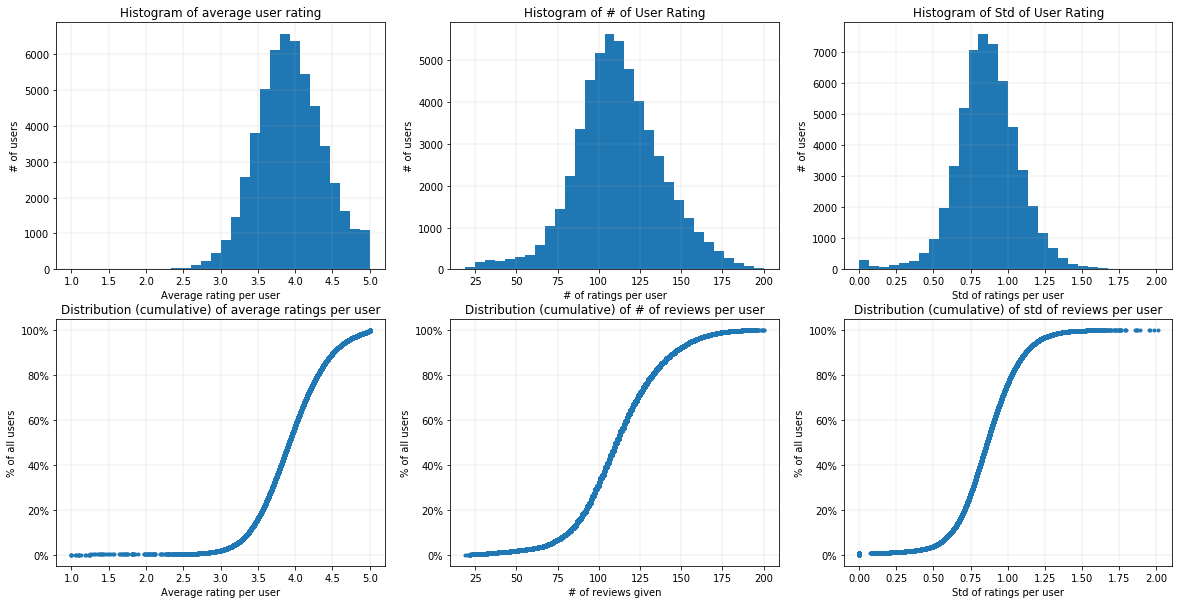

In [17]:
#Examine User rating stats
user_stats = df_ratings.groupby('user_id')['rating'].agg(['mean', 'count','std','var'])

print('User rating stats')
print(user_stats.head())

plt.figure(figsize=(20,10))

# Distribution of average rating per user
ax1 = plt.subplot(2,3,1)
user_stats['mean'].plot(kind='hist', bins=30, ax=ax1);
ax1.set_xlabel('Average rating per user');
ax1.set_ylabel('# of users');
ax1.set_title('Histogram of average user rating', fontsize=12);
ax1.grid(linewidth=.2);

# Distribution of rating standard deviation per user
ax2 = plt.subplot(2,3,2)
user_stats['count'].plot(kind='hist', bins=30, ax=ax2);
ax2.set_xlabel('# of ratings per user');
ax2.set_ylabel('# of users');
ax2.set_title('Histogram of # of User Rating', fontsize=12);
ax2.grid(linewidth=.2);


# Distribution of rating standard deviation per user
ax3 = plt.subplot(2,3,3)
user_stats['std'].plot(kind='hist', bins=30, ax=ax3);
ax3.set_xlabel('Std of ratings per user');
ax3.set_ylabel('# of users');
ax3.set_title('Histogram of Std of User Rating', fontsize=12);
ax3.grid(linewidth=.2);

# Cumulative distributions
def ecdf(array):
    """Compute ECDF for 1D array of measurement data."""
    # sort array to use as the x axis
    x = np.sort(array)    
    # use np.arange to create the y axis for cdf from 1/len to 1
    y = np.arange(1, len(array)+1)/len(array)
    return x,y

# Distribution of average user ratings
ax4 = plt.subplot(2,3,4)
x,y = ecdf(user_stats['mean'])
ax4.plot(x, y, marker = '.', linestyle='none');
ax4.set_yticklabels(['{:.0%}'.format(x) for x in ax4.get_yticks()])
ax4.set_xlabel('Average rating per user');
ax4.set_ylabel('% of all users');
ax4.set_title('Distribution (cumulative) of average ratings per user');
ax4.grid(linewidth=.2);

# Distribution of number of user ratings
ax5 = plt.subplot(2,3,5)
x,y = ecdf(user_stats['count'])
ax5.plot(x, y, marker = '.', linestyle='none');
ax5.set_yticklabels(['{:.0%}'.format(x) for x in ax5.get_yticks()])
ax5.set_xlabel('# of reviews given');
ax5.set_ylabel('% of all users');
ax5.set_title('Distribution (cumulative) of # of reviews per user');
ax5.grid(linewidth=.2);

# Distribution of standard deviation of user ratings
ax6 = plt.subplot(2,3,6)
x,y = ecdf(user_stats['std'])
ax6.plot(x, y, marker = '.', linestyle='none');
ax6.set_yticklabels(['{:.0%}'.format(x) for x in ax6.get_yticks()])
ax6.set_xlabel('Std of ratings per user');
ax6.set_ylabel('% of all users');
ax6.set_title('Distribution (cumulative) of std of reviews per user');
ax6.grid(linewidth=.2);

* The 

/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 360x360 with 0 Axes>

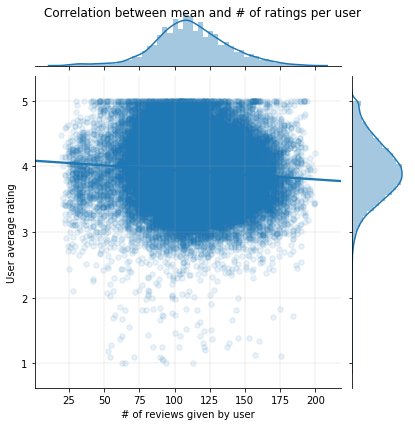

<Figure size 360x360 with 0 Axes>

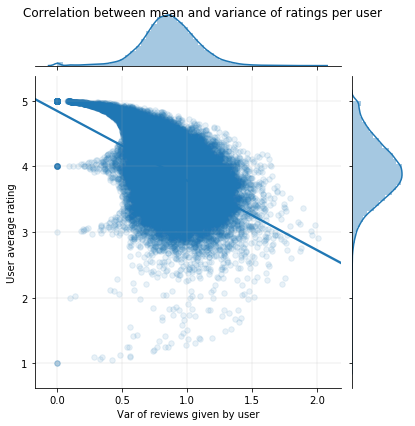

In [18]:
# Correlation between mean and number of ratings per user
## Users rate slightly lower when they rate more books. The average converges to the mean.
## Most users give rating between 3 and 5 stars, with very few averages below 3. They rate between 60 and 175 books.
## 

plt.figure(figsize=(5,5))
sns.jointplot(x="count", y="mean", data=user_stats, kind="reg", 
            scatter_kws={'alpha':0.1, 's':30})
plt.xlabel('# of reviews given by user')
plt.ylabel('User average rating')
plt.suptitle('Correlation between mean and # of ratings per user')
plt.grid(linewidth=.2)

# Correlation between mean and standard deviation of ratings per user
## There appears to be only a slight rise in average rating when a book is reviewed more often.

plt.figure(figsize=(5,5))
sns.jointplot(x="std", y="mean", data=user_stats, kind="reg", 
            scatter_kws={'alpha':0.1, 's':30})
plt.xlabel('Var of reviews given by user')
plt.ylabel('User average rating')
plt.suptitle('Correlation between mean and variance of ratings per user')
plt.grid(linewidth=.2)


plt.show()

In this dataset, users who give ratings with an average below 2-stars have rated at least 50 books. These low raters are spread evenly from 50 to nearly 200 reviews each.

/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 360x360 with 0 Axes>

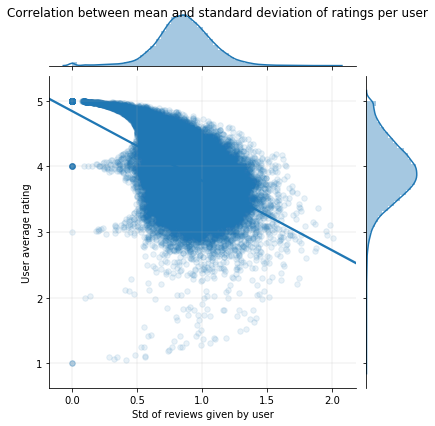

In [19]:
# Correlation between std and number of ratings per user
## 

plt.figure(figsize=(5,5))
sns.jointplot(x="std", y="mean", data=user_stats, kind="reg", 
            scatter_kws={'alpha':0.1, 's':30})
plt.xlabel('Std of reviews given by user')
plt.ylabel('User average rating')
plt.suptitle('Correlation between mean and standard deviation of ratings per user')
plt.grid(linewidth=.2)
plt.show()

* Users with 

In [20]:
print("20:", 20//50*50)
print("99:", 99//50*50)
print("101:", 101//50*50)

20: 0
99: 50
101: 100


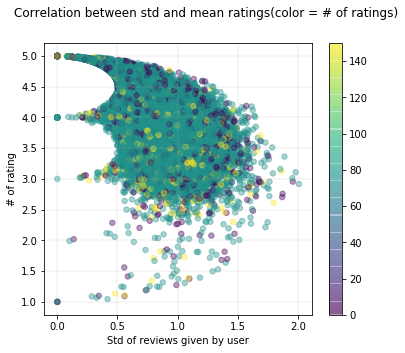

In [21]:
# Correlation between std and mean ratings per user
## Color points based on the number of ratings each user gave (0-75 vs 76-150 vs 151-200)

colors = user_stats['count']//75*75

# ?? How do I customize the palette to use colorblind-safe colors??
#current_palette = sns.color_palette("cubehelix", 8)
#current_palette = plt.cm.cubehelix


plt.figure(figsize=(6,5))
plt.scatter(x=user_stats['std'], y=user_stats['mean'], c=colors, s=30, alpha=0.4)
plt.xlabel('Std of reviews given by user')
plt.ylabel('# of rating')
plt.suptitle('Correlation between std and mean ratings(color = # of ratings)')
plt.colorbar()
plt.grid(linewidth=.2)
plt.show()

/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


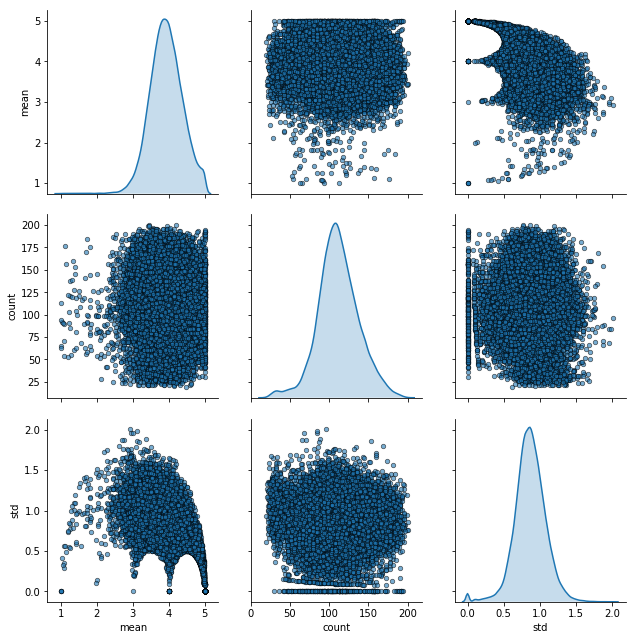

In [22]:
# Create a pair plot with a density plot of the # diagonal and format the scatter plots.

# Consider coloring it by a variable like: hue = (2-10, 11-100, 101-200 ratings given)

sns.pairplot(user_stats[['mean', 'count', 'std']], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor': 'k'},
             height = 3)
plt.show()

In [23]:
import numpy as np
def compute_dimensions(length):
    """
    Given an integer, compute the "square-est" pair of dimensions for plotting.
    
    Examples:
    - length: 17 => rows: 4, cols: 5
    - length: 14 => rows: 4, cols: 4
    
    This is a utility function; can be tested separately.
    """
    sqrt = np.sqrt(length)
    floor = int(np.floor(sqrt))
    ceil = int(np.ceil(sqrt))
    
    if floor ** 2 >= length:
        return (floor, floor)
    elif floor * ceil >= length:
        return (floor, ceil)
    else:
        return (ceil, ceil)
    
compute_dimensions(length=17)

assert compute_dimensions(17) == (4, 5)
assert compute_dimensions(16) == (4, 4)
assert compute_dimensions(15) == (4, 4)
assert compute_dimensions(11) == (3, 4)

# Next, let's visualize the empirical CDF for each column of data.
import matplotlib.pyplot as plt

def empirical_cumdist(data, ax, title=None):
    """
    Plots the empirical cumulative distribution of values.
    """
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    ax.scatter(x, y)
    ax.set_title(title)
 


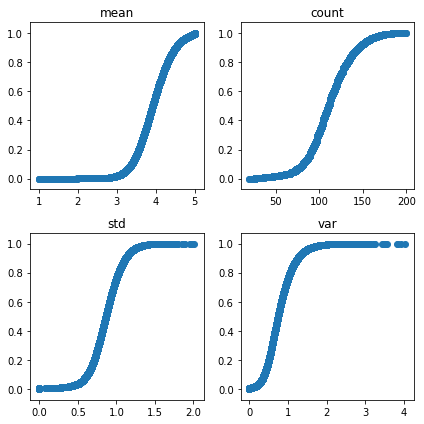

In [24]:
# Visualize distribution of each column

data_cols = [i for i in user_stats.columns if i not in ['Year', 'Month']]
n_rows, n_cols = compute_dimensions(len(data_cols))

fig = plt.figure(figsize=(n_cols*3, n_rows*3))
from matplotlib.gridspec import GridSpec
gs = GridSpec(n_rows, n_cols)
for i, col in enumerate(data_cols):
    ax = plt.subplot(gs[i])
    empirical_cumdist(user_stats[col], ax, title=col)
    
plt.tight_layout()
plt.show()

## Genres

In [25]:
genres = ["art", "biography", "business", "chick-lit", "childrens", "christian", "classics", 
          "comics", "contemporary", "cookbooks", "crime", 'erotica', "fantasy", "graphic-novels", 
          'historical', "historical-fiction", "history", "horror", "humor", "manga", "memoir", 
          "music", "mystery", "paranormal", "philosophy", "poetry", "psychology", 'reference', 
          "religion", "romance", "science", "science-fiction", "self-help", 'short-stories', 
          "suspense", "spirituality", "thriller", "travel", "young-adult"]

sub_genres = ['action', 'adult-fiction', 'adventure', 'american', 'contemporary-romance', 
               'dark', 'drama', 'dystopia', 'feminism', 'funny', 
               'historical-romance', 'literature', 'literary-fiction', 'lgbt', 'love', 
               'magic', 'mystery-thriller', 'mythology', 'paranormal-romance', 'politics', 
               'realistic-fiction', 'school', 'speculative-fiction', 'urban-fantasy', 
               'vampires', 'war', 'sports'] 

fiction_vs_non = ['fiction', 'non-fiction']
reading_levels = ['adult', 'young-adult', 'high-school', 'middle-grade', 'picture-books', 'childrens'] 
other_tags = ['to-read', 'ebooks', 'ebook', 'unfinished']

In [26]:
# Merge book_tags and tag description data on 'tag_id'
df_book_tags_desc = pd.merge(df_book_tags, df_tags, on='tag_id')
df_book_tags_desc.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,2,30574,24549,to-read
2,3,30574,496107,to-read
3,5,30574,11909,to-read
4,6,30574,298,to-read


In [27]:
# Determine which tags are used most often, in order to narrow down the list
# Group by tag_name and count number of books they've been used for.
tag_frequency = df_book_tags_desc.groupby(['tag_name'])['goodreads_book_id'].count() \
                .sort_values(ascending=False)

print(tag_frequency.head(20))
#print(tag_frequency[49:100])

tag_name
to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
default              8239
ebook                8054
my-books             7561
audiobook            7242
ebooks               7203
wish-list            7192
my-library           7000
audiobooks           6862
i-own                6670
adult                6604
Name: goodreads_book_id, dtype: int64


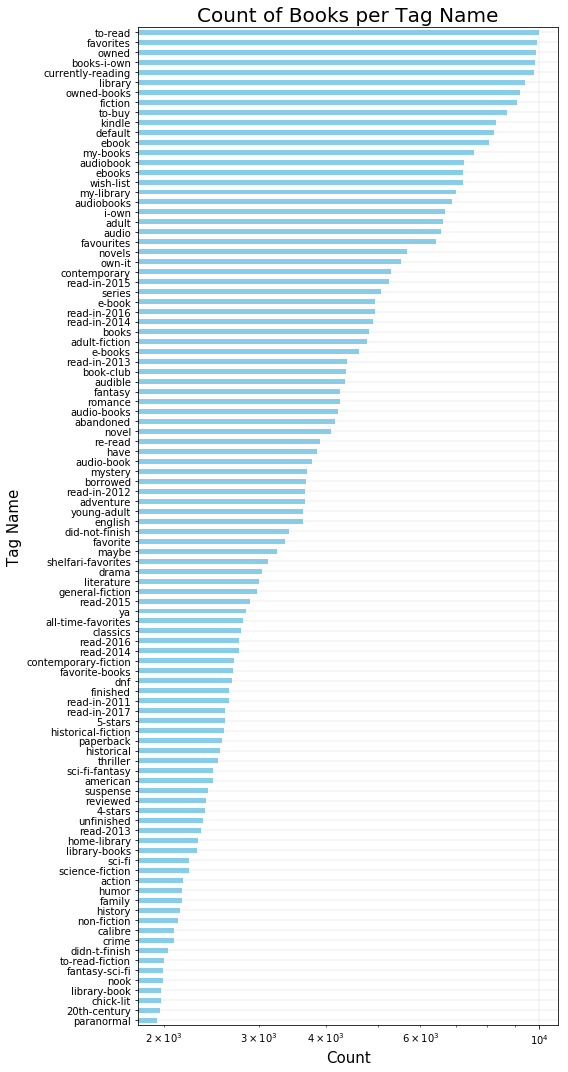

In [28]:
#Remove tags used less than X times

#Histogram of tags
fig = plt.figure(figsize = (8,15))
_ = tag_frequency[:100].sort_values().plot.barh(color="skyblue")

# Include numeric counts on each bar
#for i, v in enumerate(tag_frequency):
#    plt.text(200, i, str(v), va = 'center', color='black') #, fontweight='bold')

_ = plt.title('Count of Books per Tag Name', fontsize=20)
_ = plt.xlabel('Count', fontsize=15)
_ = plt.ylabel('Tag Name', fontsize=15)
#_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
_ = plt.grid(linewidth=.2)
_ = plt.xscale('log')

plt.tight_layout()

plt.show()

In [29]:
tag_frequency.describe()

count    34252.000000
mean        29.192806
std        277.254715
min          1.000000
25%          1.000000
50%          1.000000
75%          5.000000
max       9983.000000
Name: goodreads_book_id, dtype: float64

In [30]:
len(tag_frequency[tag_frequency > 1000])

186

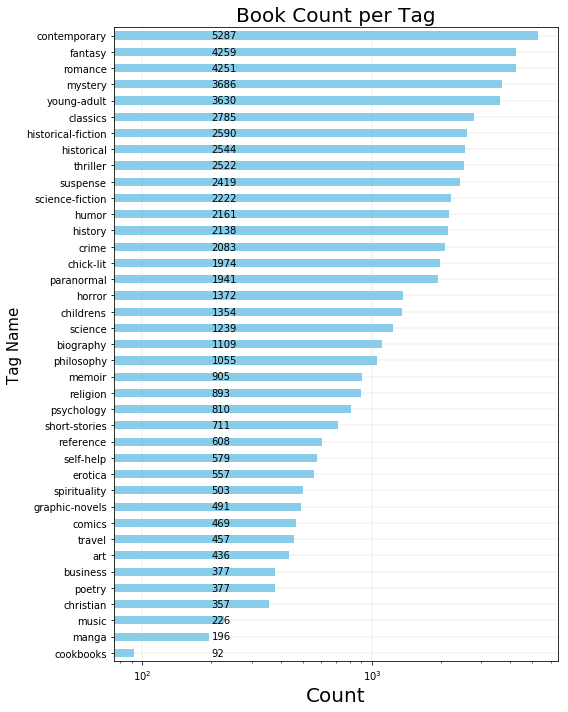

In [31]:
#Histogram of main genre tags
tags = tag_frequency.loc[genres].sort_values()

fig = plt.figure(figsize = (8,10))
_ = tags.plot.barh(color="skyblue")

# Include numeric counts on each bar
for i, v in enumerate(tags):
    plt.text(200, i, str(v), va = 'center', color='black') #, fontweight='bold')

_ = plt.grid(linewidth=.2)
_ = plt.xscale('log')
_ = plt.title('Book Count per Tag', fontsize=20)
_ = plt.xlabel('Count', fontsize=20)
_ = plt.ylabel('Tag Name', fontsize=15)

plt.tight_layout()
plt.show()

# Network Analysis of Books & Users
* Bipartite Graph

- need to differentiate user and book IDs, so user 2 and book 2 aren't the same

In [32]:
df_ratings.head(20)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
5,2,26,4
6,2,315,3
7,2,33,4
8,2,301,5
9,2,2686,5


In [33]:
# Create graph from ratings dataframe

G=nx.from_pandas_edgelist(df_ratings, 'user_id','book_id', ['rating'])

/Users/langhan/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


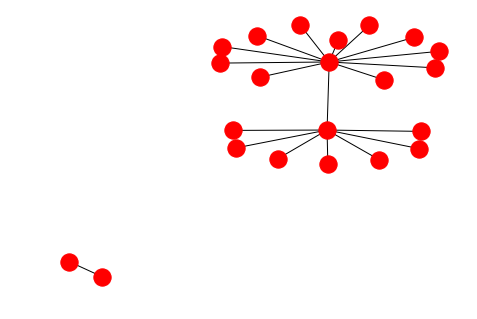

In [34]:
G_20=nx.from_pandas_edgelist(df_ratings.head(20), 'user_id','book_id', ['rating'])

# Plot it
nx.draw(G_20)
plt.show()

# Limitations
* The tag information doesn't include how each user tagged each book.
